# Import

## Modules

In [28]:
import sys
from datetime import timedelta, datetime
from pathlib import Path

import arviz as az
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pymc3 as pm
import seaborn as sns
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.model_selection import train_test_split


Setup figure plot settings

In [2]:
%config InlineBackend.figure_format = 'retina'
az.style.use("arviz-darkgrid")
sns.set_palette("deep")

 Setup paths to import scripts

In [3]:
PROJECT_ROOT = Path.cwd().parent.resolve()
sys.path.append(str(PROJECT_ROOT))

## Scripts

In [4]:
from src.data.make_dataset import get_cases_data, to_datetime, subset_latest_outbreak, get_daily_cases_stats

## Data

In [5]:
raw_cases_data = get_cases_data()

## Audit

In [6]:
raw_cases_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9866 entries, 0 to 9865
Data columns (total 7 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   notification_date           9866 non-null   object 
 1   postcode                    9061 non-null   object 
 2   likely_source_of_infection  9866 non-null   object 
 3   lhd_2010_code               9050 non-null   object 
 4   lhd_2010_name               9050 non-null   object 
 5   lga_code19                  9050 non-null   float64
 6   lga_name19                  9050 non-null   object 
dtypes: float64(1), object(6)
memory usage: 539.7+ KB


In [7]:
raw_cases_data.head()

,notification_date,postcode,likely_source_of_infection,lhd_2010_code,lhd_2010_name,lga_code19,lga_name19
0,2020-01-25,2134,Overseas,X700,Sydney,11300.0,Burwood (A)
1,2020-01-25,2121,Overseas,X760,Northern Sydney,16260.0,Parramatta (C)
2,2020-01-25,2071,Overseas,X760,Northern Sydney,14500.0,Ku-ring-gai (A)
3,2020-01-27,2033,Overseas,X720,South Eastern Sydney,16550.0,Randwick (C)
4,2020-03-01,2077,Overseas,X760,Northern Sydney,14000.0,Hornsby (A)


# Preprocess Raw Data

In [8]:
# Transform column notification_date to datetime
raw_cases_data = to_datetime('notification_date', raw_cases_data)

# Subset data to the latest outbreak
interim_data = subset_latest_outbreak('2021-06-01', 'Overseas', raw_cases_data)

# Aggregate number of cases by day
data = get_daily_cases_stats(interim_data)
data

,notification_date,Daily Number of Cases,Pct Change,Cumsum,Daily Difference,Growth Factor,Weekly Rolling Average,Weekly Average CumSum,Epidemiological Days
0,2021-06-16,3,NaN,3,NaN,NaN,NaN,NaN,-24.0
1,2021-06-17,1,-0.666667,4,-2.0,NaN,NaN,NaN,-23.0
2,2021-06-18,2,1.000000,6,1.0,-0.500000,NaN,NaN,-22.0
3,2021-06-19,1,-0.500000,7,-1.0,-1.000000,NaN,NaN,-21.0
4,2021-06-20,2,1.000000,9,1.0,-1.000000,NaN,NaN,-20.0
5,2021-06-21,5,1.500000,14,3.0,3.000000,NaN,NaN,-19.0
6,2021-06-22,17,2.400000,31,12.0,4.000000,4.0,4.0,-18.0
7,2021-06-23,12,-0.294118,43,-5.0,-0.416667,6.0,10.0,-17.0
8,2021-06-24,21,0.750000,64,9.0,-1.800000,9.0,19.0,-16.0
9,2021-06-25,28,0.333333,92,7.0,0.777778,12.0,31.0,-15.0


## Split Predictor and Target Columns

Get initial number of cases, based on weekly rolling mean

In [9]:
mask = data['Epidemiological Days'] == 0
initial_number_of_cases = data.loc[mask, 'Weekly Rolling Average'].values[0]
print(f"Initial number of cases: {initial_number_of_cases}")

Initial number of cases: 45.0


Split predictor and target columns

In [10]:
mask = data['Epidemiological Days'] >= 0
X = data.loc[mask, ["Epidemiological Days", 'Daily Number of Cases', 'Pct Change']]
y = data.loc[mask, "Weekly Rolling Average"]

# Model Training

## Data Preparation

Train-test split

In [11]:
train_size = 0.7
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=train_size)

Setting up initial parameters for Bayesian modelling

In [12]:
daily_number_of_cases_std = X_train['Daily Number of Cases'].std()
average_pct_change = X_train['Pct Change'].mean()
std_pct_change = X_train['Pct Change'].std()

print(f"Daily number of cases std: {daily_number_of_cases_std}")
print(f"Average percenntage change: {average_pct_change}")
print(f"Standard deviation of percentage change: {std_pct_change}")

Daily number of cases std: 48.96283771519154
Average percenntage change: 0.10203126654564262
Standard deviation of percentage change: 0.35077546910006835


Selecting only epidemiological days for predictor and define datasets as `np.ndarray` objects

In [13]:
X_train = X_train["Epidemiological Days"].values
y_train = y_train.values
X_test = X_test["Epidemiological Days"].values
y_test = y_test.values

X = X["Epidemiological Days"].values
y = y.values

## Train Model

In [14]:
# Create PyMC3 context manager
with pm.Model() as model:

    # Setup data for the model
    t = pm.Data("X", X_train)
    cases = pm.Data("y", y_train)

    # Intercept
    a = pm.Normal("a", mu=initial_number_of_cases, sigma=daily_number_of_cases_std)

    # Slope 
    b = pm.Normal("b", mu=average_pct_change, sigma=std_pct_change)

    # Exponential regression
    growth = a * (1 + b) ** t

    # Likelihood error
    eps = pm.HalfNormal("eps")

    # Likelihood - Counts here, so poission or negative binomial. Causes issues. Lognormal tends to work better?
    pm.Lognormal("cases", mu=np.log(growth), sigma=eps, observed=cases)

    trace = pm.sample(1000, tune=1000, cores=5, return_inferencedata=True)
    post_Pred = pm.sample_posterior_predictive(trace)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (5 chains in 5 jobs)
NUTS: [eps, b, a]


Sampling 5 chains for 1_000 tune and 1_000 draw iterations (5_000 + 5_000 draws total) took 9 seconds.
The acceptance probability does not match the target. It is 0.7107206410456166, but should be close to 0.8. Try to increase the number of tuning steps.


## Model Evaluation

In [15]:
# Update data reference.
pm.set_data({"X": X_test}, model=model)

# Generate posterior samples
post_pred_test = pm.sample_posterior_predictive(trace, model=model, samples=1000)

/home/vscode/.local/lib/python3.9/site-packages/pymc3/sampling.py:1689: UserWarning: samples parameter is smaller than nchains times ndraws, some draws and/or chains may not be represented in the returned posterior predictive sample
  warnings.warn(


Get test prediction datam

In [16]:
y_pred = np.mean(post_pred_test["cases"].T, axis=1)
y_std = np.std(post_pred_test["cases"].T, axis=1)

Define custom metrics for model performance evaluation

In [17]:
def point_set_distance(y_pred: np.ndarray, y_pred_std: np.ndarray, y_true: np.ndarray
                        ) -> np.ndarray:
    """Compute the point-to-set distance between the predicted and true values.

    Args:
        y_pred (np.ndarray): Numpy array. Predicted value.
        y_true (np.ndarray): Numpy array. True value.
        y_pred_std (np.ndarray, optional): Standard deviation of the predicted value.

    Returns:
        np.ndarray: point-to-set distance: Numpy array.

    References:
        [1] https://math.stackexchange.com/questions/2099527/distance-between-a-point-and-a-set-or-closure-of-it
    """
    assert y_pred.shape == y_true.shape, "The shapes of the predicted and true values do not match."
    assert y_pred.shape == y_pred_std.shape, "The shapes of predicted and std values do not match."

    return np.where(y_pred - y_pred_std <= y_true <= y_pred + y_pred_std, 0
            ,min(abs(y_true - (y_pred + y_pred_std))
                ,abs(y_true - (y_pred - y_pred_std))
                )
            )


def mean_squared_relative_error(y_pred: np.ndarray, y_true: np.ndarray
                                ,distance: str=None, y_pred_std: np.ndarray=None
                                ) -> float:
    """Compute the mean squared relative error between the predicted and true values.

    Args:
        y_pred (np.ndarray): Numpy array. Predicted value.
        y_true (np.ndarray): Numpy array. True value.
        distance (str, optional): Distance metric to use. Defaults to None.
        y_pred_std (np.ndarray, optional): Standard deviation of the predicted value.

    Returns:
        float: mean squared relative error: Numpy array. Mean squared relative error between the predicted and true values.

    References:
        [1] https://stats.stackexchange.com/questions/413209/is-there-something-like-a-root-mean-square-relative-error-rmsre-or-what-is-t
    """
    if distance == "point to set":
        d = point_set_distance(y_pred, y_pred_std, y_true)

    else:
        d = y_pred - y_true

    return (d**2/y_true**2).mean()


def relative_mean_squared_error(y_pred: np.ndarray, y_true: np.ndarray
                                ,distance: str=None, y_pred_std: np.ndarray=None
                                ) -> float:
    """Compute reative mean squared error between the predicted and true values.

    Args:
        y_pred (np.ndarray): Numpy array. Predicted value.
        y_true (np.ndarray): Numpy array. True value.
        distance (str, optional): Distance metric to use. Defaults to None.
        y_pred_std (np.ndarray, optional): Standard deviation of the predicted value.

    Returns:
        float: Relative mean squared error between the predicted and true values.

    References:
        [1] https://stats.stackexchange.com/questions/413209/is-there-something-like-a-root-mean-square-relative-error-rmsre-or-what-is-t
    """

    if distance == "point to set":
        d = point_set_distance(y_pred, y_pred_std, y_true)

    else:
        d = y_pred - y_true

    return (d**2).mean()/(y_true**2).sum()



Calculate performance metrics

In [18]:
r2 = r2_score(y_pred, y_test)

rmse = np.sqrt(mean_squared_error(y_pred, y_test))
rmsre = np.sqrt(mean_squared_relative_error(y_pred, y_test))
rrmse = np.sqrt(relative_mean_squared_error(y_pred, y_test))
mae = mean_absolute_error(y_pred, y_test)
rmae = (abs(y_pred - y_test) / y_test).mean()
print(f"R2 = {r2}")
print(f"RMSE = {rmse}, RMSRE = {rmsre}, RRMSE = {rrmse}")
print(f"MAE = {mae}, RMAE = {rmae}")

R2 = 0.9910291163774714
RMSE = 4.316352815060885, RMSRE = 0.037899078504485754, RRMSE = 0.010460942745351115
MAE = 3.8186188659121463, RMAE = 0.031623869664044436


Plot residuals

/home/vscode/.local/lib/python3.9/site-packages/seaborn/axisgrid.py:1668: UserWarning: This figure was using constrained_layout, but that is incompatible with subplots_adjust and/or tight_layout; disabling constrained_layout.
  f.tight_layout()


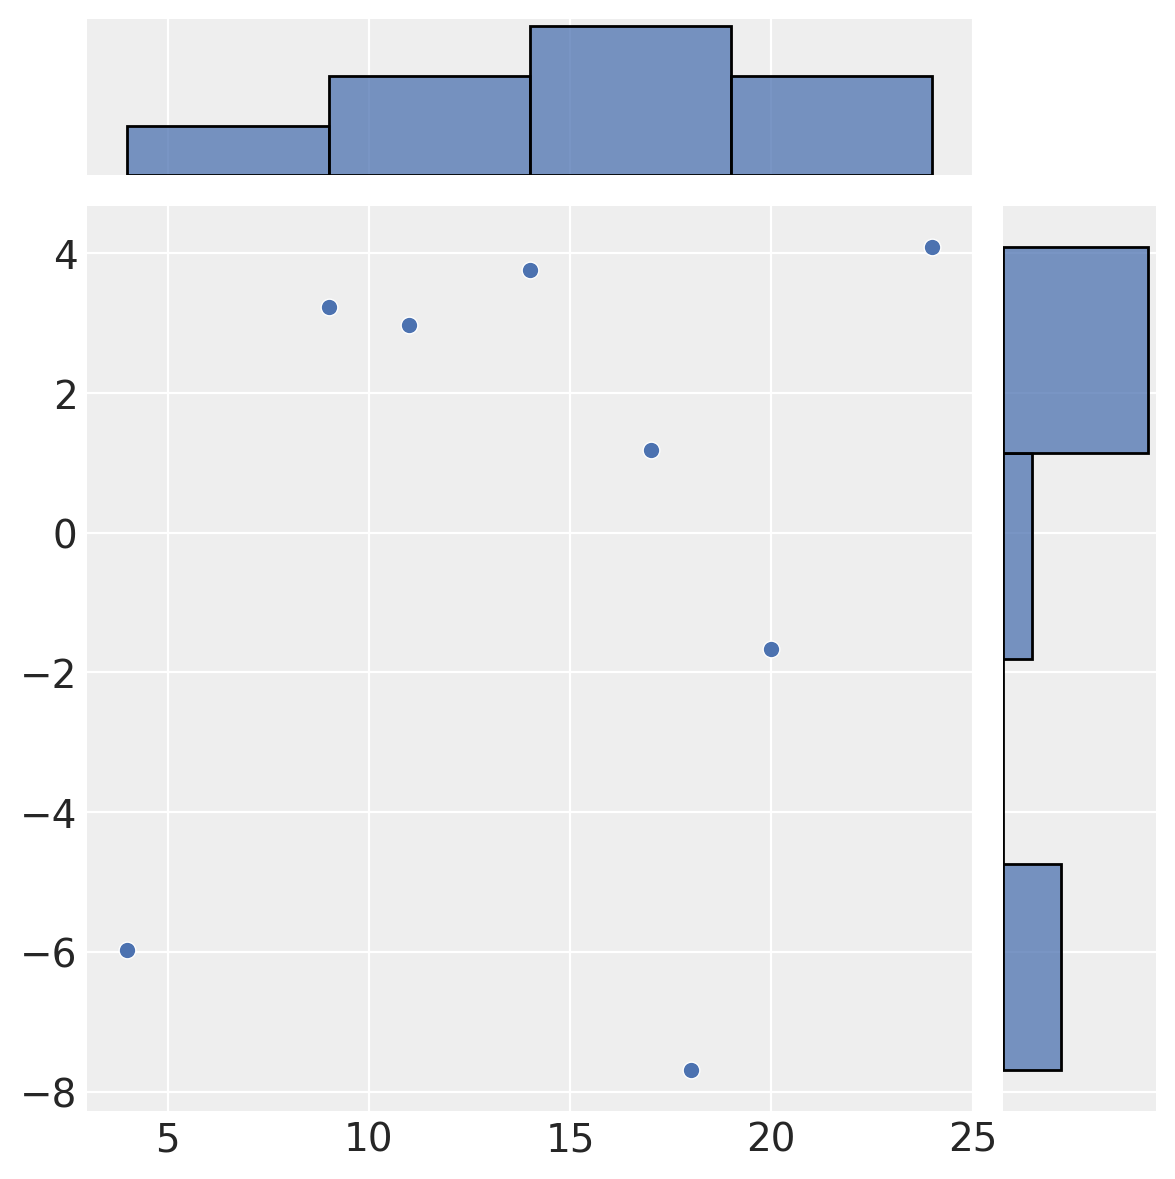

In [19]:
sns.jointplot(x=X_test, y=y_pred - y_test, marker="o")

# Model Inference

Distribution of model parameters

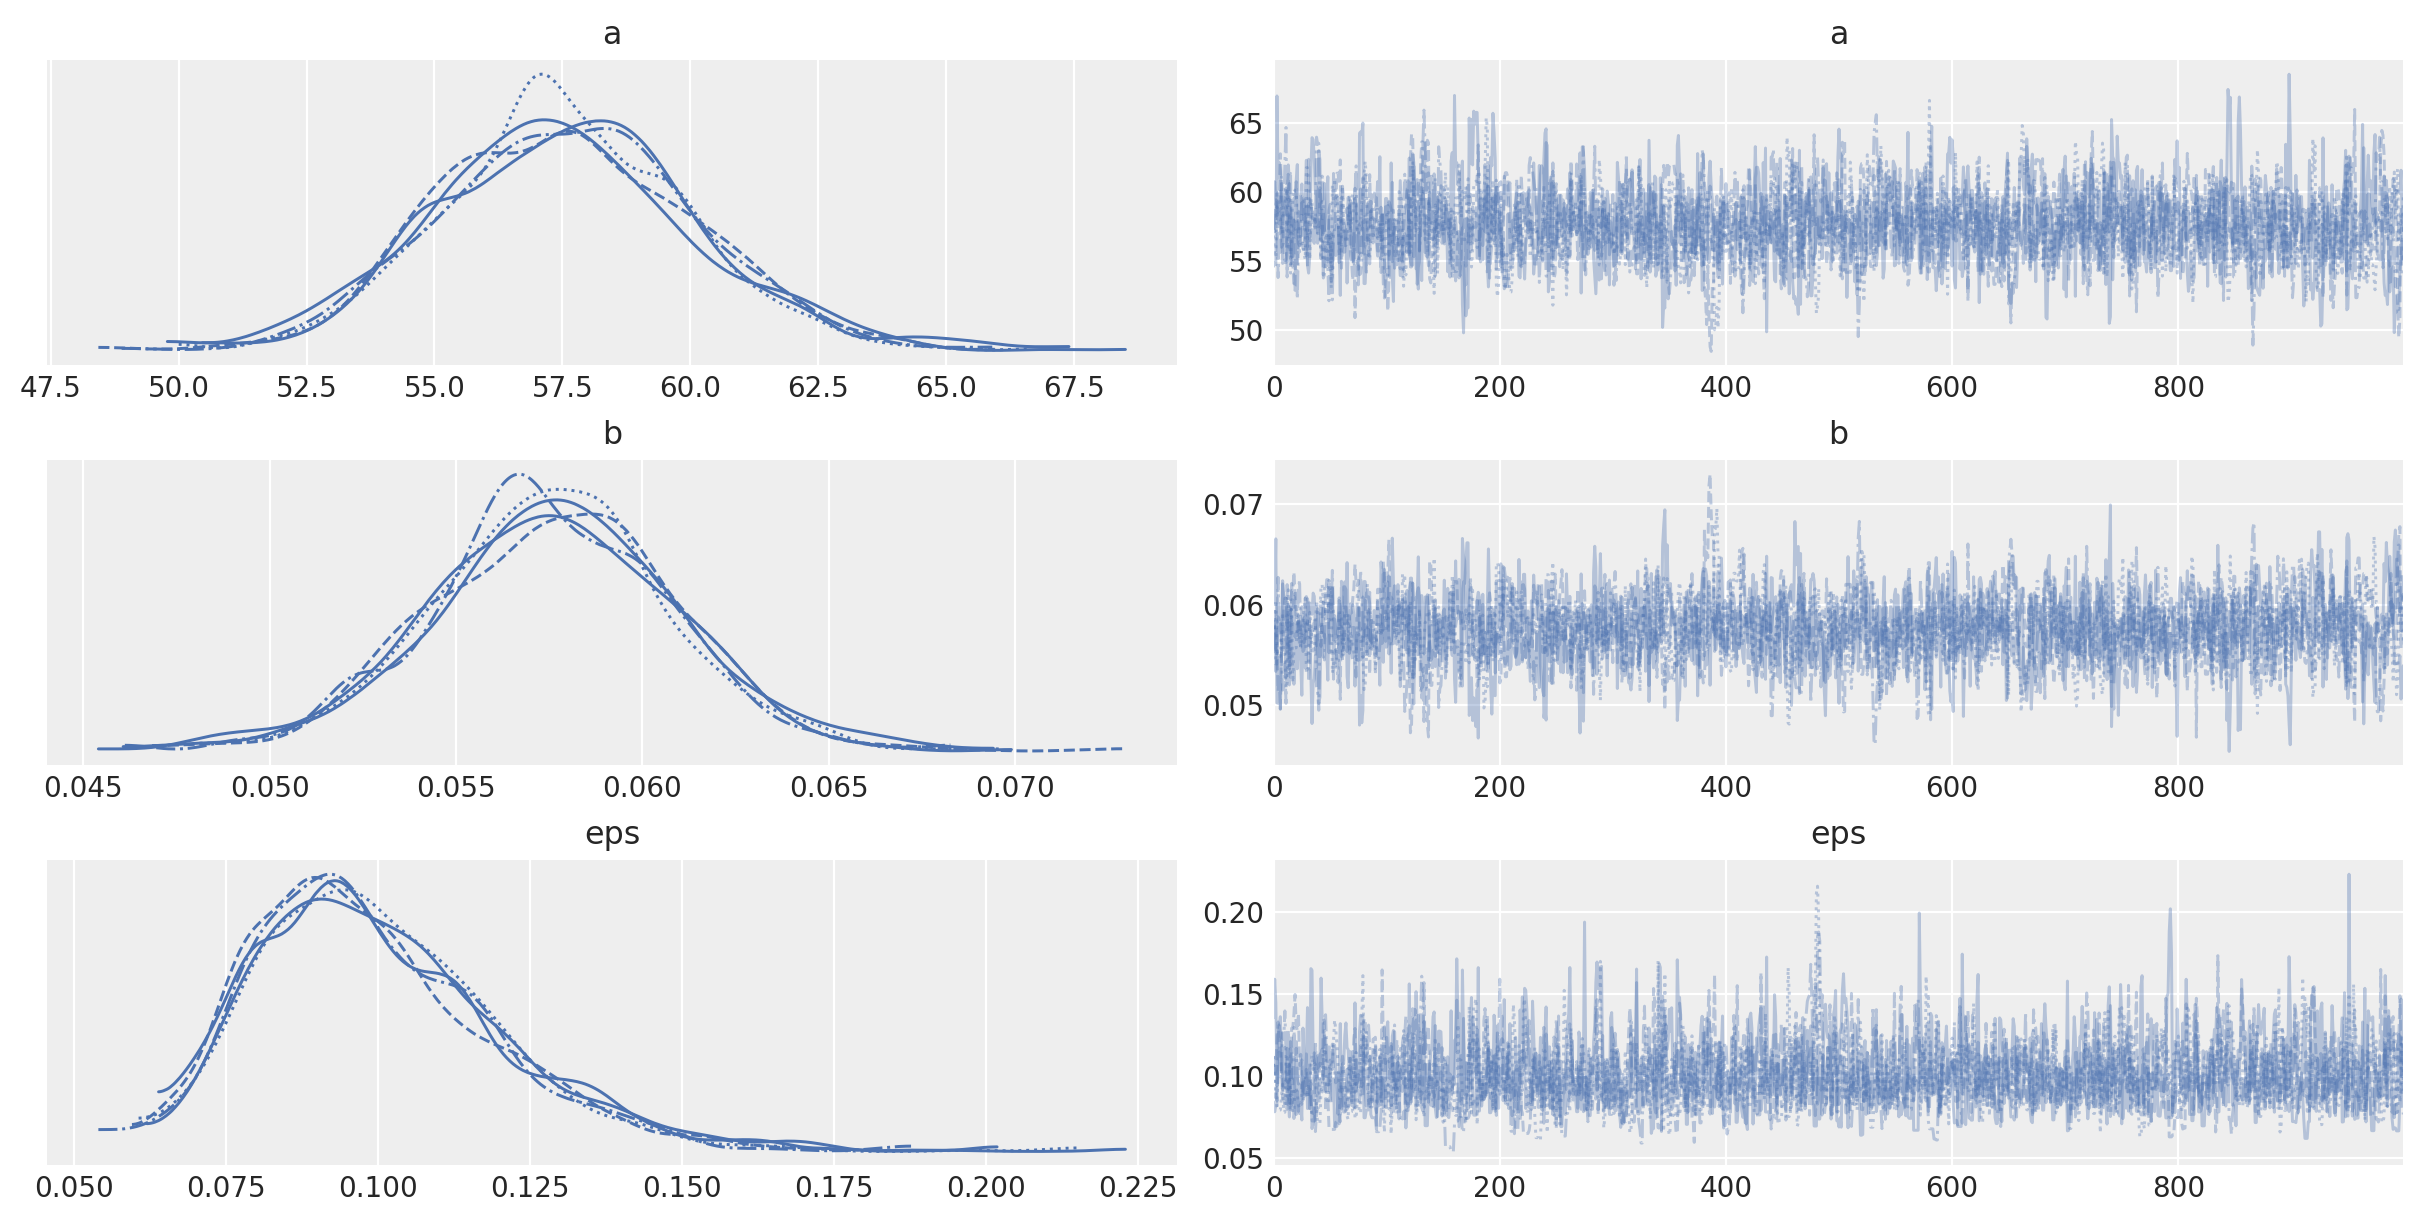

In [20]:
az.plot_trace(trace)
plt.show()

Summary of model parameters

In [21]:
pm.summary(trace).round(3)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
a,57.568,2.531,53.030,62.360,0.062,0.044,1689.0,1689.0,1.0
b,0.058,0.003,0.052,0.064,0.000,0.000,1737.0,2161.0,1.0
eps,0.100,0.020,0.066,0.137,0.000,0.000,1700.0,1373.0,1.0


## Predict on Whole Data Set

In [22]:
# Update data reference.
pm.set_data({"X": X}, model=model)

# Generate posterior samples
post_pred = pm.sample_posterior_predictive(trace, model=model, samples=1000)

/home/vscode/.local/lib/python3.9/site-packages/pymc3/sampling.py:1689: UserWarning: samples parameter is smaller than nchains times ndraws, some draws and/or chains may not be represented in the returned posterior predictive sample
  warnings.warn(


Plot model posterior predictive and actual weekly rolling average for positive values of epidemiological days

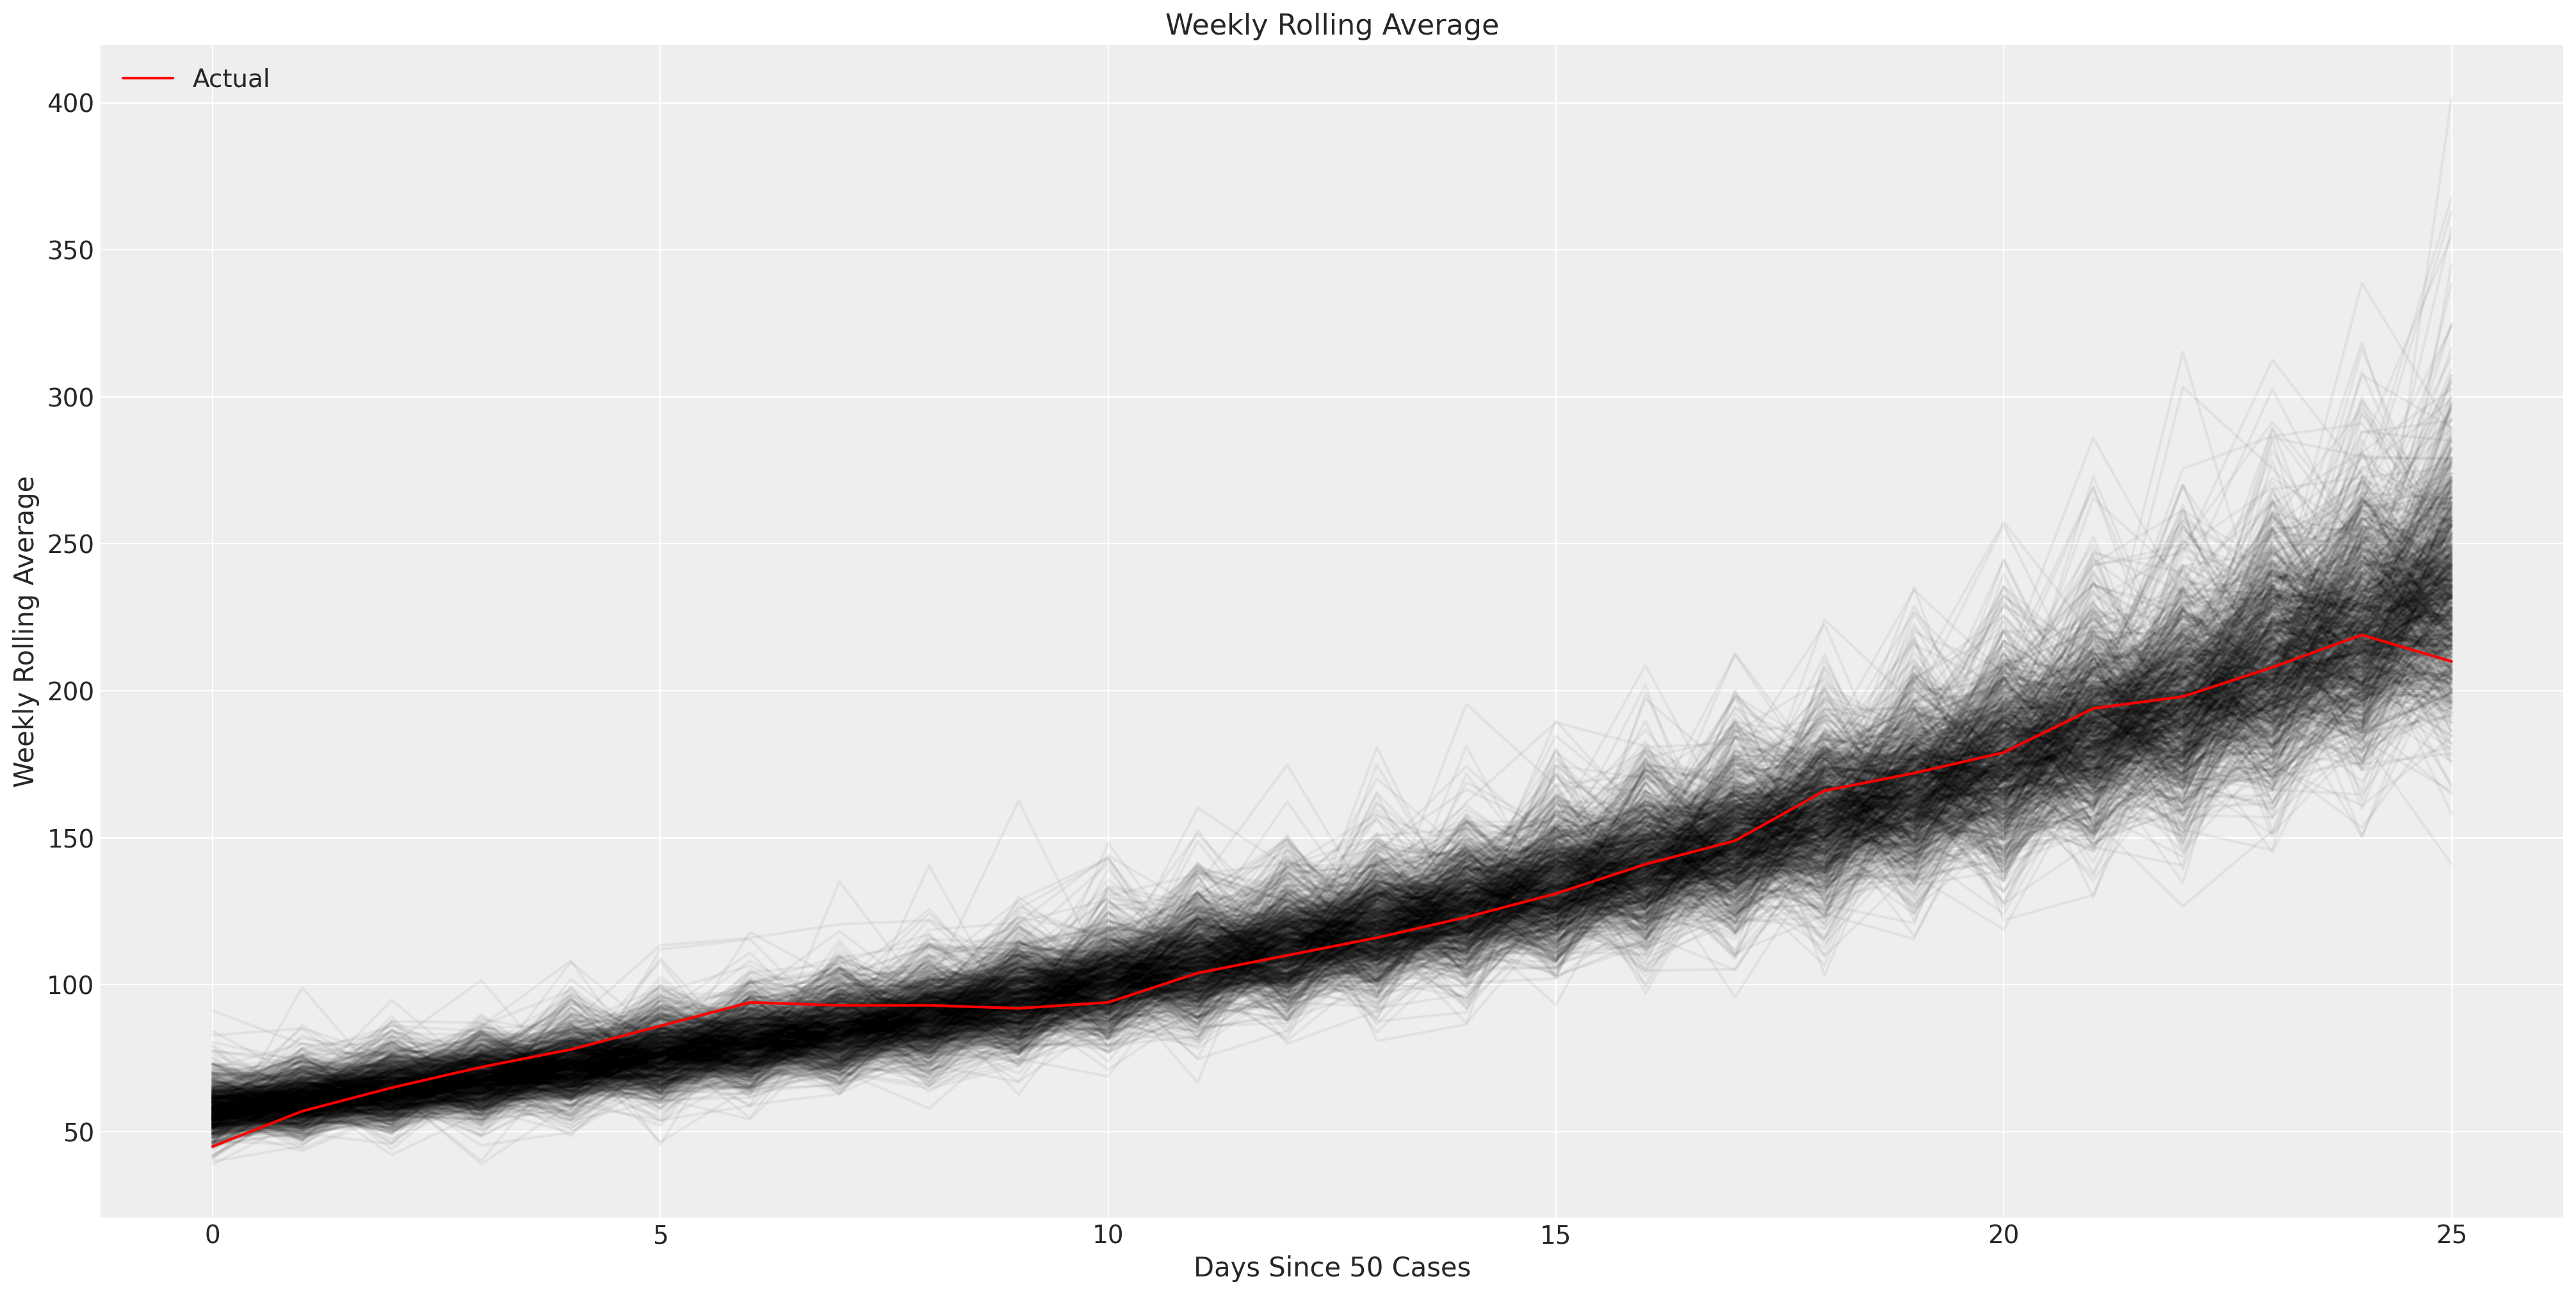

In [23]:
mask = data['Epidemiological Days'] >= 0

fig, ax = plt.subplots(figsize=(20, 10))
ax.plot(X, post_pred["cases"].T, color="k", alpha=0.05)
ax.plot(X, data.loc[mask, "Weekly Rolling Average"], color="r", label="Actual")
ax.set(xlabel="Days Since 50 Cases", ylabel="Weekly Rolling Average", title="Weekly Rolling Average")
ax.legend()

# Seven Days Forecast

In [24]:
# Augment epidemioligical days
forecast_ndays = 7
X_forecast = np.append(X, list(np.arange(X.max() + 1, X.max() + forecast_ndays + 1)))

# Update data reference.
pm.set_data({"X": X_forecast}, model=model)

# Generate posterior samples
post_pred_forecast = pm.sample_posterior_predictive(trace, model=model, samples=1000)

/home/vscode/.local/lib/python3.9/site-packages/pymc3/sampling.py:1689: UserWarning: samples parameter is smaller than nchains times ndraws, some draws and/or chains may not be represented in the returned posterior predictive sample
  warnings.warn(


Create data set containing forecasted data

In [31]:
mask = data["Epidemiological Days"] >= 0
data_forecast = pd.DataFrame({"Epidemiological Days": X_forecast
                            ,"Weekly Rolling Average": data.loc[mask, "Weekly Rolling Average"].append(pd.Series([np.nan]*forecast_ndays))
                            ,"Predicted Weekly Rolling Average": np.mean(post_pred_forecast["cases"].T, axis=1)
                            ,"notification_date": data.loc[mask, "notification_date"].append(pd.Series([data["notification_date"].max() + timedelta(days=day) for day in range(1, forecast_ndays+1)]))
                            ,"Predicted Weekly Rolling Std": np.std(post_pred_forecast["cases"].T, axis=1)
                            })
data_forecast.reset_index(inplace=True, drop=True)
data_forecast["Prediction Lower Bound"] = data_forecast["Predicted Weekly Rolling Average"] - data_forecast["Predicted Weekly Rolling Std"]
data_forecast["Prediction Upper Bound"] = data_forecast["Predicted Weekly Rolling Average"] + data_forecast["Predicted Weekly Rolling Std"]
data_forecast["Forecast_On_Date"] = datetime.now().date()
data_forecast[["Predicted Weekly Rolling Average", "Prediction Lower Bound", "Prediction Upper Bound", "Forecast_On_Date", "notification_date"]].to_csv(str(PROJECT_ROOT / "data" / "processed" / f"predicted_weekly_rolling_average_{datetime.now().date()}.csv"), index=False)
data_forecast

,Epidemiological Days,Weekly Rolling Average,Predicted Weekly Rolling Average,notification_date,Predicted Weekly Rolling Std,Prediction Lower Bound,Prediction Upper Bound,Forecast_On_Date
0,0.0,45.0,57.728660,2021-07-10,6.510189,51.218471,64.238849,2021-08-05
1,1.0,57.0,60.985388,2021-07-11,7.003808,53.981580,67.989196,2021-08-05
2,2.0,65.0,64.840075,2021-07-12,6.899948,57.940127,71.740024,2021-08-05
3,3.0,72.0,68.322332,2021-07-13,7.825483,60.496849,76.147815,2021-08-05
4,4.0,78.0,72.444751,2021-07-14,8.078799,64.365952,80.523550,2021-08-05
5,5.0,86.0,76.267843,2021-07-15,8.193374,68.074470,84.461217,2021-08-05
6,6.0,94.0,81.088064,2021-07-16,9.023904,72.064160,90.111968,2021-08-05
7,7.0,93.0,85.061184,2021-07-17,9.378873,75.682311,94.440056,2021-08-05
8,8.0,93.0,90.173764,2021-07-18,9.675357,80.498406,99.849121,2021-08-05
9,9.0,92.0,95.678141,2021-07-19,10.480104,85.198038,106.158245,2021-08-05


Plot actual and forecasted values

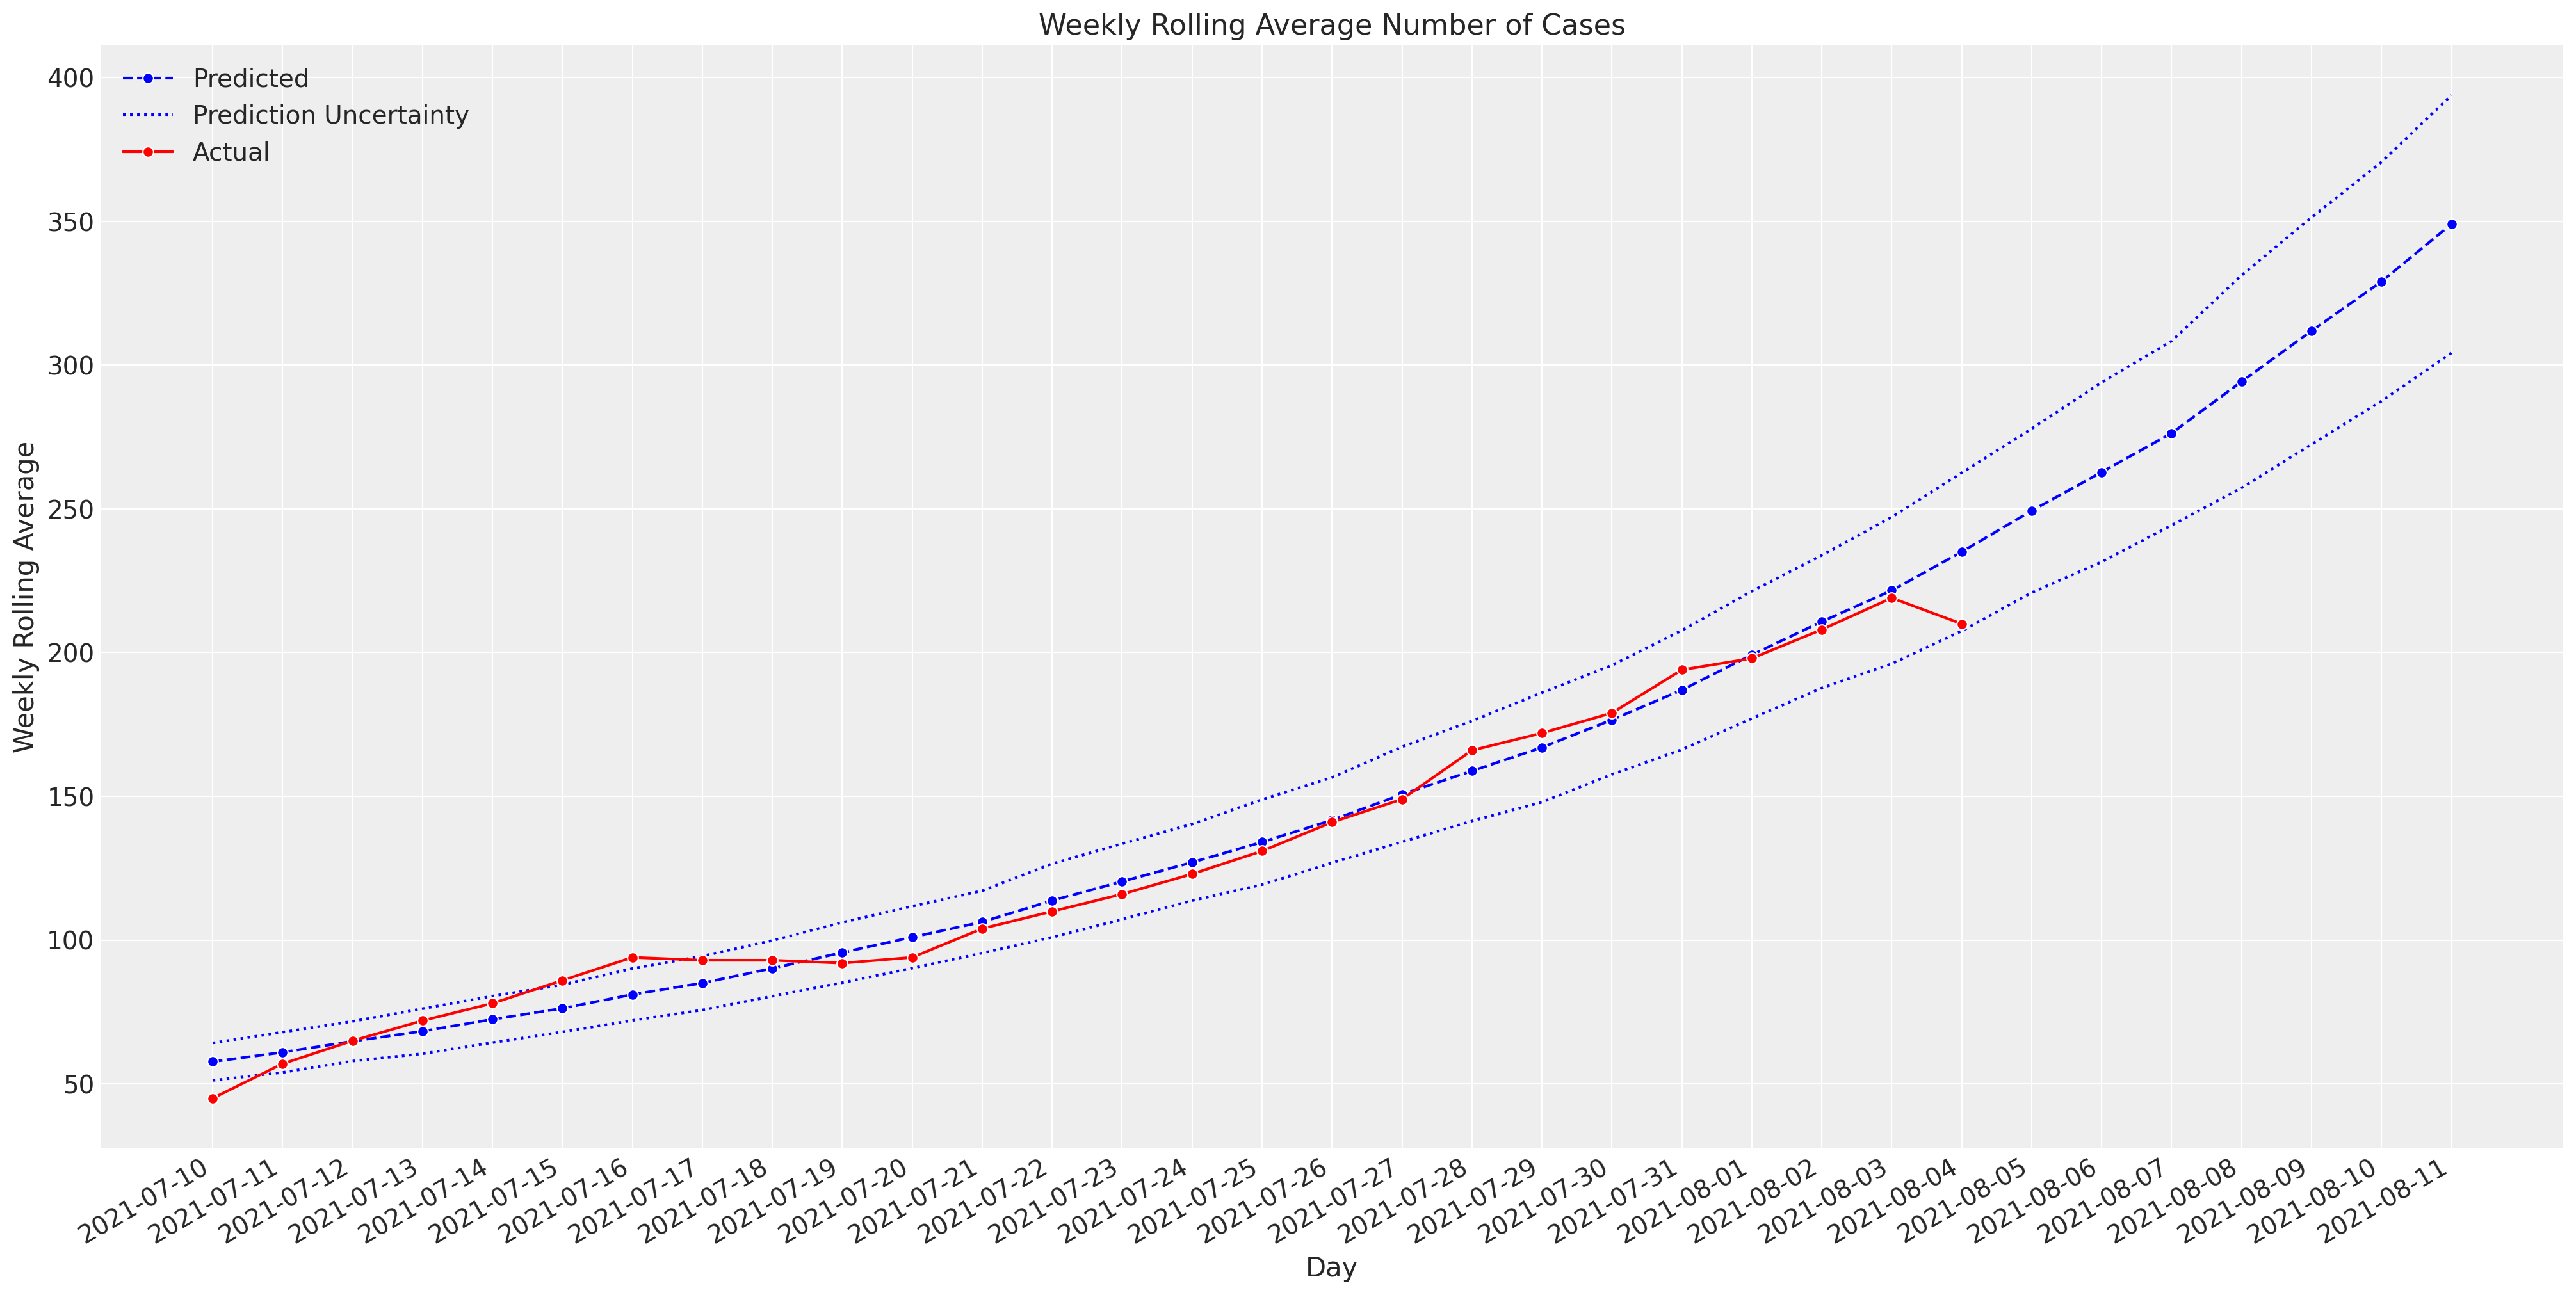

In [26]:
forecast_std = np.std(post_pred_forecast["cases"].T, axis=1)

fig, ax = plt.subplots(figsize=(20, 10))
ax = sns.lineplot(x=data_forecast["Epidemiological Days"], y=np.mean(post_pred_forecast["cases"].T, axis=1), color="b", marker="o", label="Predicted", linestyle="--", ax=ax)
ax = sns.lineplot(x=data_forecast["Epidemiological Days"], y=np.mean(post_pred_forecast["cases"].T, axis=1) + forecast_std, color="b", linestyle=":", label="Prediction Uncertainty", ax=ax)
ax = sns.lineplot(x=data_forecast["Epidemiological Days"], y=np.mean(post_pred_forecast["cases"].T, axis=1) - forecast_std, color="b", linestyle=":", ax=ax)
ax = sns.lineplot(x=data_forecast["Epidemiological Days"], y=data_forecast["Weekly Rolling Average"], color="r", label="Actual", marker="o", ax=ax)

plt.xticks(data_forecast["Epidemiological Days"], data_forecast["notification_date"].astype(str), rotation = 30, ha="right")

ax.set(xlabel="Day", ylabel="Weekly Rolling Average", title="Weekly Rolling Average Number of Cases")
ax.legend()
ax.grid(True)

In [30]:
%load_ext watermark
%watermark -n -u -v -iv -w

Last updated: Wed Aug 04 2021

Python implementation: CPython
Python version       : 3.9.2
IPython version      : 7.25.0

pandas    : 1.3.0
matplotlib: 3.4.2
seaborn   : 0.11.1
pymc3     : 3.11.2
sys       : 3.9.2 (default, Mar 12 2021, 19:04:51) 
[GCC 8.3.0]
arviz     : 0.11.2
numpy     : 1.19.5

Watermark: 2.2.0

